<div>
<img src="../Figures/KoalaFramework-Logo%20copy%202.jpg" width="250"/>
</div>

# Qoala-T Notebook, January 2020

Qoala-T is a supervised learning tool that asseses accuracy of manual quality control of T1 imaging scans and their automated neuroanatomical labeling processed in FreeSurfer. It is particularly intended to use in developmental datasets. 

More information about Qoala-T can be found on GitHub (https://github.com/Qoala-T/QC) and in the accompanying Open Access paper:   
Klapwijk, E.T., van de Kamp, F., Meulen, M., Peters, S., Wierenga, L.M. (2019). Qoala-T: A supervised-learning tool for quality control of FreeSurfer segmented MRI data. _NeuroImage, 189_, 116-129. https://doi.org/10.1016/j.neuroimage.2019.01.014


The protocol of our in house developed manual QC procedure can be found here (https://github.com/Qoala-T/QC/blob/master/Qoala-T_Manual.pdf).

This notebook was created by Eduard Klapwijk (https://github.com/eduardklap) based on code written by Lara Wierenga (https://github.com/larawierenga) and Olga Veth (https://github.com/OPVeth)
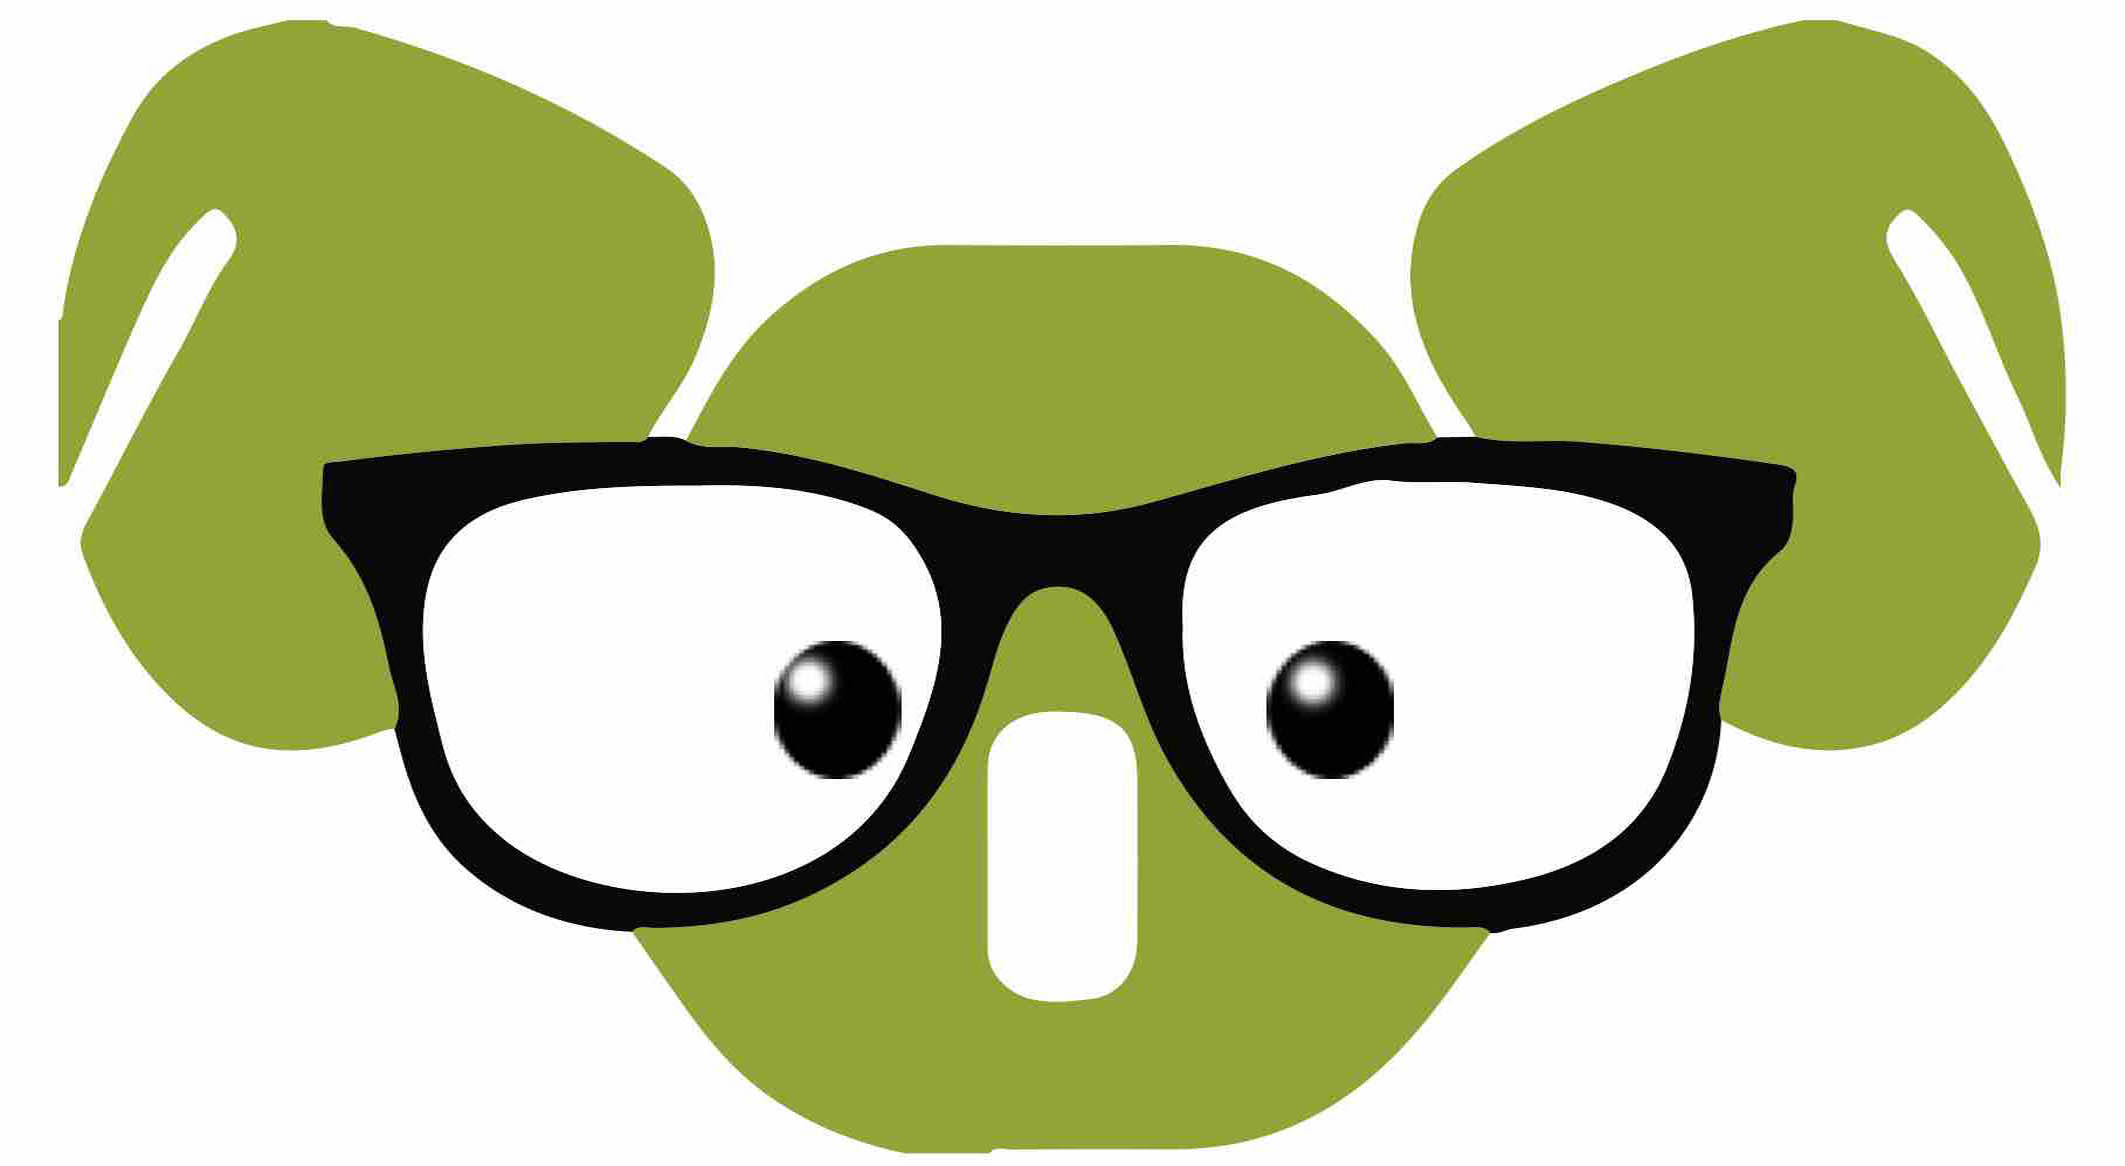

## Using this notebook
Once you have processed MRI data using FreeSurfer, you can use this notebook to extract the necessary information needed to perform Qoala-T calculations. Next, within this notebook you can run Qoala-T based on the BrainTime model.

## Step 1: process images in FreeSurfer v6.0
To be able to run the Qoala-T model, T1 MRI images should be processed in FreeSurfer V6.0 (https://surfer.nmr.mgh.harvard.edu/fswiki/DownloadAndInstall). This should be done before using this notebook

## Step 2: Install packages
Run the next block of code to install and load the packages needed to run Qoala-T

In [ ]:
packages <- c("caret", "corrplot", "gbm", "plyr", "randomForest", "e1071",
              "pROC", "DMwR","dplyr","pbkrtest","car","pbkrtest","doParallel","ROSE","repmis", "plotly", "r2d3")
if (length(setdiff(packages, rownames(installed.packages()))) > 0) {
  install.packages(setdiff(packages, rownames(installed.packages())))  
}
lapply(packages, library, character.only = TRUE)

## Step 2: Run stats2table
- Written by Olga Veth - Leiden University, MSc Computer Science student
- Created on 30-09-2019
- Most Recent update: 16-10-19
- Version 3.0

### Two inputs should be provided by the user of this script:
1. Directory containing all the directories of the study participants with FreeSurfer output
2. Name of the study and/or dataset

In [ ]:
# 1.
datasetDir <- "F:/EMPA" # Change Directory to your data
setwd(datasetDir) 
# 2.
dataset_name <- "EMPA" # Provide name of your study and/or dataset

### Run stats2table R code
After you provided the directory and name of your dataset in the previous step, you can run the next block of code without having to make changes:

In [ ]:
readAseg <- function(){
  # The Aseg file of a subject is read in
  # Volume_mm3 and StructName are selected
  aseg_file <- data.frame(read.table(paste("./stats/aseg.stats", sep=""), row.names=1))[,c(3,4)] 
  asegTable <- t(data.frame(aseg_file[,1], row.names = aseg_file[,2])) # Aseg file - regular
  return (asegTable)
}

readMetaAseg <- function(){
  # The Aseg file of a subject is read in
  # Its metadata containing 'lhCortex' etc. and their volume are saved
  aseg_meta <- readLines("./stats/aseg.stats", n=35)[14:35]
  meta1 <- gsub("# ", "", aseg_meta)
  meta <- t(data.frame(strsplit(meta1, ",")))[,c(2,4)]
  metaTable <- t(data.frame(meta[,2]))
  colnames(metaTable) <- meta[,1]
  return(metaTable)
}

editCol <- function(side, string, add){
  # Change measure areas from 'Areaname'--> 'lh_Areaname_area'
  return(paste(side, "_", string, add, sep=""))
}

readAparc <- function(value){
  # Aparc files of lh and rh are read in and the  area and thickness values of both files are retreved as well 
    # as the metadata measurements of both parts
  # Areanames are formatted and eventually the data is saved into a data frame
  sides <- c("lh", "rh")
  ifelse((value == "area"), pos <- 1, pos <- 2)
  
  for (x in 1:length(sides)){
    areaThickness <- as.data.frame(read.table(paste("./stats/", sides[x], ".aparc.stats", sep=""), row.names=1))[, c(2,4)]
    rowValues <- rownames(areaThickness)
    
    meta <- readLines(paste("./stats/", sides[x], ".aparc.stats", sep=""))[c(20, 21)] 
    meta1 <- gsub("# ", "", meta)
    meta2 <- t(data.frame(strsplit(meta1, ",")))[, c(2,4)]
    meta3 <- data.frame(meta2[pos,2])
    value2 <- gsub(" ", "", meta2[pos,1])
    
    colnames(meta3) <- paste(sides[x], "_", value2, "_" , value, sep="")
    extra <- t(matrix(areaThickness[,pos]))
    colnames(extra) <- paste(sides[x], "_", rowValues, "_", value, sep="")
    ifelse(x==1, aparcTable <- cbind(extra, meta3), aparcTable <- cbind(aparcTable, extra, meta3))
  }
  return(aparcTable)
}

readFiles <- function(){
  # Aseg and Aparc files are read in and all the data is merged, starting with Aseg data followed with Aparc
  asegTable <- readAseg()
  metaTable <- readMetaAseg()
  
  areaAparc <- readAparc("area")
  thickAparc <- readAparc("thickness")
  
  subjectTable <- cbind(asegTable, metaTable, areaAparc, thickAparc) # aparcMeta --> WhiteSurface
  subjectTable <- data.frame(subjectTable)
  return (subjectTable)
}

preprocTable <- function(subjectTable){
  # Columnames are edited or removed from the table
  removeCols <- c("*.WM-hypointensities$","*.WM.hypointensities$", "*pole*", "*bankssts*", "VentricleChoroidVol", "*CerebralWhiteMatterVol", "\\bSurfaceHoles\\b",
                  "SegVolFile.mri.aseg.mgz.", "*CorticalWhiteMatterVol")
  remove <- grep(paste(removeCols, collapse="|"), colnames(subjectTable))
  subjectTable <- subjectTable[, -remove]
  
  colnames(subjectTable) <- gsub("^X\\.", "", colnames(subjectTable))
  colnames(subjectTable) <- gsub("_\\.", "_", colnames(subjectTable))
  colnames(subjectTable) <- gsub("-", ".", colnames(subjectTable))
  colnames(subjectTable) <- gsub(" ", "", colnames(subjectTable))
  
  colnames(subjectTable)[which(colnames(subjectTable) == "eTIV")] <- "EstimatedTotalIntraCranialVol"
  colnames(subjectTable)[which(colnames(subjectTable) %in% c("rd.Ventricle", "th.Ventricle", 
                                                             "5th.Ventricle"))] <- c("X4th.Ventricle", "X3rd.Ventricle", "X5th.Ventricle") # change to names
  
  return(subjectTable)
}

main <- function(){
  # It loops through all subjects sub-directories in the given directory
  # With every single subject, data is retrieved and written in a row in the final table. 
  # The result is saved into a .CSV file
  subjects <- c()
  first <- T
  subjectDirs <- unique(list.dirs('.', recursive=FALSE)) # Get all sample subject
  for (x in 0:length(subjectDirs)){
    setwd(paste(datasetDir, subjectDirs[x], sep=""))
    statsDirs <- list.dirs('.', recursive=FALSE)
    if (file.exists("./stats/aseg.stats")){
      subjectTable <- readFiles()
      subjectTable <- preprocTable(subjectTable)
      if (first == T){
        stats2Table <- subjectTable
        subjects <- c(subjects, substring(subjectDirs[x], 3))
        first = F
      } 
      else if (ncol(subjectTable) == ncol(stats2Table)&& (first == F)){
        stats2Table <- rbind(stats2Table, subjectTable)
        subjects <- c(subjects, substring(subjectDirs[x], 3))
      } 
      
    }
  }
  
  stats2Table <- data.frame(stats2Table)
  rownames(stats2Table) <- subjects
  setwd(datasetDir)
  write.csv(stats2Table, paste("FreeSurfer_Output_", dataset_name,".csv", sep=""))
    }
main()

### CSV output
Now there should be a csv file called "FreeSurfer_Ouput_(Dataset_name).csv" in the datasetDir that was declared by the user in the previous step.  
Let's have a look at this table:

In [ ]:
read.csv(paste("FreeSurfer_Output_",dataset_name,".csv", sep=""))

## Step 3: Run the Qoala-T model on your data

- written by Lara Wierenga, PhD at Leiden University
- Created on March 2018
- Most Recent update: 4-11-19
- Version 1.2

### Run the model and save csv output file
Now that you have your FreeSurfer output in the right format you can run the Qoala-T model based on the BrainTime training set. The results will be saved in a csv file in your dataset directory. 

In [ ]:
stats2Table <- read.csv(paste("FreeSurfer_Output_", dataset_name, ".csv", sep=""), header=T, row.names=1)
test_data <- stats2Table

githubURL <- "https://github.com/Qoala-T/QC/blob/master/Qoala_T_model.Rdata?raw=true"
rf.tune <- get(load(url(githubURL)))

# -----------------------------------------------------------------
#reorder colnames of dataset to match traningset
# -----------------------------------------------------------------
dataset_colnames <- names(rf.tune$trainingData)[-ncol(rf.tune$trainingData)]
testing <- test_data[,dataset_colnames]
testing <- testing[complete.cases(testing),]

# -----------------------------------------------------------------
## External validation of unseen data on Qoala-T model 
# -----------------------------------------------------------------
rf.pred <-  predict(rf.tune,testing)
rf.probs <- predict(rf.tune,testing,type="prob") # probability of belonging in either category (certainty..)

# -----------------------------------------------------------------
# Saving output
# ----------------------------------------------------------------
# create empty data frame
Qoala_T_predictions <- data.frame(matrix(ncol = 4, nrow = nrow(rf.probs)))                             
colnames(Qoala_T_predictions) = c('VisitID','Scan_QoalaT', 'Recommendation', 'manual_QC_adviced') 

# fill data frame
Qoala_T_predictions$VisitID <- row.names(rf.probs)
Qoala_T_predictions$Scan_QoalaT <- rf.probs$Include*100 
Qoala_T_predictions$Recommendation <- rf.pred
Qoala_T_predictions$manual_QC_adviced <- ifelse(Qoala_T_predictions$Scan_QoalaT<70&Qoala_T_predictions$Scan_QoalaT>30,"yes","no")
Qoala_T_predictions <- Qoala_T_predictions[order(Qoala_T_predictions$Scan_QoalaT, Qoala_T_predictions$VisitID),]


csv_Qoala_T_predictions = paste('Qoala_T_predictions_model_based_',dataset_name,'.csv', sep = '')
write.csv(Qoala_T_predictions, file = csv_Qoala_T_predictions, row.names=F)

### CSV output
Now there should be a csv file called "Qoala_T_predictions_model_based_(Dataset_name).csv" in the datasetDir.
Let's have a look at this table:

In [ ]:
read.csv(paste('Qoala_T_predictions_model_based_',dataset_name,'.csv', sep = ''))

### Plot results

In [ ]:
excl_rate <- table(Qoala_T_predictions$Recommendation)

fill_colour <- rev(c("#256da8","#CF4A30"))
font_size <- 12
text_col <- "Black"

p <- ggplot(Qoala_T_predictions, aes(name = VisitID, x=Scan_QoalaT,y=1,col=Recommendation)) +  
  annotate("rect", xmin=30, xmax=70, ymin=1.12, ymax=.88, alpha=0.2, fill="#777777") +
  geom_jitter(alpha=.8,height=.1,size=5) +
  ggtitle(paste("Qoala-T estimation model based for ",dataset_name,"\nMean Qoala-T Score = ",round(mean(Qoala_T_predictions$Scan_QoalaT),1),sep="")) + 
  annotate("text", x=20, y=1.15, label=paste("Excluded = ",as.character(round(excl_rate[1]))," scans",sep="")) + 
  annotate("text", x=80, y=1.15, label=paste("Included = ",as.character(round(excl_rate[2]))," scans",sep="")) + 
  scale_colour_manual(values=fill_colour) +
  theme_bw() +
  theme(panel.grid.major = element_blank(), 
        panel.grid.minor = element_blank(), 
        panel.border = element_blank(),
        axis.text.x = element_text (size = font_size,color=text_col),
        axis.text.y = element_blank(),
        axis.title.x = element_text (size = font_size,color=text_col), 
        axis.title.y = element_blank(), 
        axis.ticks=element_blank(),
        plot.title=element_text (size =16,color=text_col,hjust=.5)
  )
print(p)

filename<- paste("Figure_Rating_model_based_",dataset_name,".pdf",sep="")
dev.copy(pdf,filename,width=30/2.54, height=20/2.54)
dev.off()

## That's it! We hope these predictions help in the quality control procedure of your study.  
  
When using Qoala-T please include the following citation:
  
Klapwijk, E.T., van de Kamp, F., Meulen, M., Peters, S., Wierenga, L.M. (2019). Qoala-T: A supervised-learning tool for quality control of FreeSurfer segmented MRI data. _NeuroImage, 189_, 116-129. https://doi.org/10.1016/j.neuroimage.2019.01.014